In [1]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(tf.Session(config=config))
#import keras
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.models import Model
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from matplotlib.pyplot import imshow
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation, Conv2D, MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
train=pd.read_csv("/home/sainathb/dog breed files/Image_Classification/labels.csv")

In [3]:
ylabels=train['breed']

In [4]:
ylabels=np.array(pd.get_dummies(ylabels))
ylabels.shape

(10222, 120)

In [5]:
from keras.preprocessing import image
def read_img(img_path):
    img = image.load_img(img_path,target_size=(400,400,3))
    arr=image.img_to_array(img)
    return arr/255

In [6]:
def crop_read_img(img_path):
    img = image.load_img(img_path,target_size=(400,400,3))
    arr=image.img_to_array(img)
    return arr/255

In [7]:
trainimages=[]
for img_path in tqdm(train['id'].values):
        trainimages.append(read_img("/home/sainathb/dog breed files/Image_Classification/train/"+ img_path+".jpg"))

100%|██████████| 10222/10222 [01:22<00:00, 123.87it/s]


In [10]:
trainimages=np.array(trainimages)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=5)
for train_index, test_index in sss.split(trainimages,ylabels):
        X_train,X_test = trainimages[train_index], trainimages[test_index]
        y_train, y_test = ylabels[train_index], ylabels[test_index]

In [12]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model1= keras.applications.xception.Xception(include_top=False, weights='imagenet',input_shape=(400,400,3),pooling='avg')

base_model2= keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(400,400,3),pooling='avg')

base_model3 =InceptionResNetV2(include_top=False , weights='imagenet',input_shape=(400,400,3),pooling='avg')


In [13]:
xpreds=base_model1.predict(x=X_train,batch_size=50)
print(xpreds.shape)
ipreds=base_model2.predict(x=X_train,batch_size=50)
print(ipreds.shape)
irpreds=base_model3.predict(x=X_train,batch_size=50)
print(irpreds.shape)

(9199, 2048)
(9199, 2048)
(9199, 1536)


In [14]:
Xtrain=np.concatenate([irpreds,ipreds,xpreds],axis=-1)
Xtrain.shape

(9199, 5632)

In [15]:
xfpreds=base_model1.predict(x=np.flip(X_train,axis=2),batch_size=10)
print(xfpreds.shape)
ifpreds=base_model2.predict(x=np.flip(X_train,axis=2),batch_size=10)
print(ifpreds.shape)
irfpreds=base_model3.predict(x=np.flip(X_train,axis=2),batch_size=10)
print(irfpreds.shape)

(9199, 2048)
(9199, 2048)
(9199, 1536)


In [16]:
Xftrain=np.concatenate([irfpreds,ifpreds,xfpreds],axis=-1)
Xftrain.shape

(9199, 5632)

In [17]:
txpreds=base_model1.predict(x=X_test,batch_size=30)
tipreds=base_model2.predict(x=X_test,batch_size=30)
tirpreds=base_model3.predict(x=X_test,batch_size=30)

In [18]:
txfpreds=base_model1.predict(x=np.flip(X_test,axis=2),batch_size=50)
tifpreds=base_model2.predict(x=np.flip(X_test,axis=2),batch_size=50)
tirfpreds=base_model3.predict(x=np.flip(X_test,axis=2),batch_size=50)

In [19]:
Xtest=np.concatenate([tirpreds,tipreds,txpreds],axis=-1)
Xtest.shape

(1023, 5632)

In [20]:
Xftest=np.concatenate([tirfpreds,tifpreds,txfpreds],axis=-1)
Xftest.shape

(1023, 5632)

In [26]:
def mymodel():
    model = Sequential()
    model.add(Dense(2048,input_shape=(5632,)))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(120))
    model.add(Activation('softmax'))
    return model

In [95]:
callbacks1=keras.callbacks.ModelCheckpoint('mod1.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
callbacks2=keras.callbacks.ModelCheckpoint('mod2.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

In [98]:
tensor1=keras.callbacks.TensorBoard(log_dir='./dog breed files/logs/model1/', histogram_freq=0, batch_size=120, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
tensor2=keras.callbacks.TensorBoard(log_dir='./dog breed files/logs/model2', histogram_freq=0, batch_size=120, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [103]:
model1=mymodel()
model1.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.085, decay=0.03, momentum=0.92, nesterov=True), metrics=['accuracy'])
model1.fit(Xtrain,y_train, epochs=100,batch_size=150, shuffle=True,verbose=1,validation_data=(Xtest,y_test),callbacks=[callbacks1,tensor1])

Train on 9199 samples, validate on 1023 samples
Epoch 1/100
9199/9199 [==============================] - 2s 193us/step - loss: 0.9574 - acc: 0.8019 - val_loss: 0.1903 - val_acc: 0.9326

Epoch 00001: val_loss did not improve
Epoch 2/100
9199/9199 [==============================] - 1s 155us/step - loss: 0.1929 - acc: 0.9374 - val_loss: 0.1766 - val_acc: 0.9394

Epoch 00002: val_loss did not improve
Epoch 3/100
9199/9199 [==============================] - 1s 154us/step - loss: 0.1553 - acc: 0.9477 - val_loss: 0.1665 - val_acc: 0.9492

Epoch 00003: val_loss did not improve
Epoch 4/100
9199/9199 [==============================] - 1s 150us/step - loss: 0.1371 - acc: 0.9551 - val_loss: 0.1576 - val_acc: 0.9501

Epoch 00004: val_loss did not improve
Epoch 5/100
9199/9199 [==============================] - 1s 161us/step - loss: 0.1278 - acc: 0.9574 - val_loss: 0.1624 - val_acc: 0.9472

Epoch 00005: val_loss did not improve
Epoch 6/100
9199/9199 [==============================] - 1s 151us/step -


Epoch 00046: val_loss did not improve
Epoch 47/100
9199/9199 [==============================] - 1s 156us/step - loss: 0.0779 - acc: 0.9778 - val_loss: 0.1604 - val_acc: 0.9482

Epoch 00047: val_loss did not improve
Epoch 48/100
9199/9199 [==============================] - 1s 153us/step - loss: 0.0766 - acc: 0.9801 - val_loss: 0.1599 - val_acc: 0.9501

Epoch 00048: val_loss did not improve
Epoch 49/100
9199/9199 [==============================] - 1s 155us/step - loss: 0.0757 - acc: 0.9795 - val_loss: 0.1601 - val_acc: 0.9492

Epoch 00049: val_loss did not improve
Epoch 50/100
9199/9199 [==============================] - 1s 152us/step - loss: 0.0748 - acc: 0.9781 - val_loss: 0.1605 - val_acc: 0.9492

Epoch 00050: val_loss did not improve
Epoch 51/100
9199/9199 [==============================] - 1s 158us/step - loss: 0.0745 - acc: 0.9798 - val_loss: 0.1605 - val_acc: 0.9492

Epoch 00051: val_loss did not improve
Epoch 52/100
9199/9199 [==============================] - 1s 158us/step - lo

9199/9199 [==============================] - 1s 156us/step - loss: 0.0679 - acc: 0.9830 - val_loss: 0.1615 - val_acc: 0.9492

Epoch 00093: val_loss did not improve
Epoch 94/100
9199/9199 [==============================] - 1s 154us/step - loss: 0.0674 - acc: 0.9823 - val_loss: 0.1614 - val_acc: 0.9492

Epoch 00094: val_loss did not improve
Epoch 95/100
9199/9199 [==============================] - 2s 164us/step - loss: 0.0674 - acc: 0.9813 - val_loss: 0.1612 - val_acc: 0.9492

Epoch 00095: val_loss did not improve
Epoch 96/100
9199/9199 [==============================] - 1s 153us/step - loss: 0.0689 - acc: 0.9812 - val_loss: 0.1614 - val_acc: 0.9482

Epoch 00096: val_loss did not improve
Epoch 97/100
9199/9199 [==============================] - 1s 154us/step - loss: 0.0678 - acc: 0.9830 - val_loss: 0.1618 - val_acc: 0.9482

Epoch 00097: val_loss did not improve
Epoch 98/100
9199/9199 [==============================] - 1s 153us/step - loss: 0.0669 - acc: 0.9824 - val_loss: 0.1617 - val_ac

In [104]:
model2=mymodel()
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.085, decay=0.03, momentum=0.92, nesterov=True), metrics=['accuracy'])
model2.fit(Xftrain,y_train, epochs=150,batch_size=120, shuffle=True,verbose=1,validation_data=(Xftest,y_test),callbacks=[callbacks2,tensor2])
   

Train on 9199 samples, validate on 1023 samples
Epoch 1/150
9199/9199 [==============================] - 2s 190us/step - loss: 0.8406 - acc: 0.8163 - val_loss: 0.2061 - val_acc: 0.9335

Epoch 00001: val_loss improved from inf to 0.20609, saving model to mod2.h5
Epoch 2/150
9199/9199 [==============================] - 1s 160us/step - loss: 0.1890 - acc: 0.9381 - val_loss: 0.1742 - val_acc: 0.9433

Epoch 00002: val_loss improved from 0.20609 to 0.17423, saving model to mod2.h5
Epoch 3/150
9199/9199 [==============================] - 1s 153us/step - loss: 0.1510 - acc: 0.9515 - val_loss: 0.1785 - val_acc: 0.9443

Epoch 00003: val_loss did not improve
Epoch 4/150
9199/9199 [==============================] - 1s 161us/step - loss: 0.1357 - acc: 0.9548 - val_loss: 0.1622 - val_acc: 0.9541

Epoch 00004: val_loss improved from 0.17423 to 0.16218, saving model to mod2.h5
Epoch 5/150
9199/9199 [==============================] - 1s 158us/step - loss: 0.1236 - acc: 0.9591 - val_loss: 0.1645 - val_a


Epoch 00045: val_loss did not improve
Epoch 46/150
9199/9199 [==============================] - 1s 129us/step - loss: 0.0734 - acc: 0.9793 - val_loss: 0.1584 - val_acc: 0.9531

Epoch 00046: val_loss did not improve
Epoch 47/150
9199/9199 [==============================] - 1s 122us/step - loss: 0.0767 - acc: 0.9784 - val_loss: 0.1592 - val_acc: 0.9521

Epoch 00047: val_loss did not improve
Epoch 48/150
9199/9199 [==============================] - 1s 115us/step - loss: 0.0749 - acc: 0.9790 - val_loss: 0.1596 - val_acc: 0.9501

Epoch 00048: val_loss did not improve
Epoch 49/150
9199/9199 [==============================] - 1s 120us/step - loss: 0.0754 - acc: 0.9772 - val_loss: 0.1589 - val_acc: 0.9521

Epoch 00049: val_loss did not improve
Epoch 50/150
9199/9199 [==============================] - 1s 117us/step - loss: 0.0761 - acc: 0.9787 - val_loss: 0.1594 - val_acc: 0.9492

Epoch 00050: val_loss did not improve
Epoch 51/150
9199/9199 [==============================] - 1s 139us/step - lo

9199/9199 [==============================] - 1s 156us/step - loss: 0.0666 - acc: 0.9822 - val_loss: 0.1592 - val_acc: 0.9511

Epoch 00092: val_loss did not improve
Epoch 93/150
9199/9199 [==============================] - 1s 152us/step - loss: 0.0688 - acc: 0.9823 - val_loss: 0.1594 - val_acc: 0.9511

Epoch 00093: val_loss did not improve
Epoch 94/150
9199/9199 [==============================] - 1s 159us/step - loss: 0.0674 - acc: 0.9827 - val_loss: 0.1594 - val_acc: 0.9501

Epoch 00094: val_loss did not improve
Epoch 95/150
9199/9199 [==============================] - 1s 149us/step - loss: 0.0665 - acc: 0.9804 - val_loss: 0.1593 - val_acc: 0.9511

Epoch 00095: val_loss did not improve
Epoch 96/150
9199/9199 [==============================] - 1s 150us/step - loss: 0.0659 - acc: 0.9826 - val_loss: 0.1595 - val_acc: 0.9511

Epoch 00096: val_loss did not improve
Epoch 97/150
9199/9199 [==============================] - 1s 156us/step - loss: 0.0658 - acc: 0.9826 - val_loss: 0.1592 - val_ac

9199/9199 [==============================] - 1s 151us/step - loss: 0.0639 - acc: 0.9827 - val_loss: 0.1599 - val_acc: 0.9511

Epoch 00138: val_loss did not improve
Epoch 139/150
9199/9199 [==============================] - 1s 153us/step - loss: 0.0629 - acc: 0.9845 - val_loss: 0.1601 - val_acc: 0.9511

Epoch 00139: val_loss did not improve
Epoch 140/150
9199/9199 [==============================] - 1s 152us/step - loss: 0.0642 - acc: 0.9825 - val_loss: 0.1602 - val_acc: 0.9501

Epoch 00140: val_loss did not improve
Epoch 141/150
9199/9199 [==============================] - 1s 150us/step - loss: 0.0648 - acc: 0.9834 - val_loss: 0.1602 - val_acc: 0.9501

Epoch 00141: val_loss did not improve
Epoch 142/150
9199/9199 [==============================] - 1s 155us/step - loss: 0.0634 - acc: 0.9830 - val_loss: 0.1602 - val_acc: 0.9492

Epoch 00142: val_loss did not improve
Epoch 143/150
9199/9199 [==============================] - 1s 161us/step - loss: 0.0647 - acc: 0.9822 - val_loss: 0.1601 - v

In [29]:
from tqdm import tqdm
import cv2
test=pd.read_csv("/home/sainathb/dog breed files/Image_Classification/sample_submission.csv")
xtest=[]
for img_path in tqdm(test['id'].values):
        xtest.append(read_img("/home/sainathb/dog breed files/Image_Classification/test/"+ img_path+".jpg"))
xtest=np.array(xtest)

100%|██████████| 10357/10357 [01:12<00:00, 142.16it/s]


In [31]:
model1.load_weights('./mod1.h5')
model2.load_weights('./mod2.h5')

In [32]:
pxpreds=base_model1.predict(x=xtest,batch_size=10)
pipreds=base_model2.predict(x=xtest,batch_size=10)
pirpreds=base_model3.predict(x=xtest,batch_size=10)


In [33]:
pXtest=np.concatenate([pirpreds,pipreds,pxpreds],axis=-1)
pXtest.shape

(10357, 5632)

In [34]:
pxfpreds=base_model1.predict(x=np.flip(xtest,axis=2),batch_size=50)
pifpreds=base_model2.predict(x=np.flip(xtest,axis=2),batch_size=50)
pirfpreds=base_model3.predict(x=np.flip(xtest,axis=2),batch_size=50)

In [35]:
pXftest=np.concatenate([pirfpreds,pifpreds,pxfpreds],axis=-1)
pXftest.shape

(10357, 5632)

In [36]:
a=model1.predict(pXtest)
b=model2.predict(pXftest)

In [37]:
e=(a+b)/2

In [92]:
e.shape

(10357, 120)

In [91]:
np.savetxt('zeropoint15.csv',e, delimiter=',',fmt="%f")

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.style.use('ggplot')

%matplotlib inline

In [73]:
preds=np.argmax((model1.predict(Xtest)+model2.predict(Xftest))/2,1)

In [74]:
preds.shape

(1023,)

In [75]:
y=np.array(y_test)

In [76]:
y=np.argmax(y,1)

In [77]:
y.shape

(1023,)

In [78]:
breeds=np.unique(train['breed'].values)

In [79]:
pr=[]
for i in preds:
    pr.append(breeds[i])

In [80]:
pr1=[]
for i in y:
    pr1.append(breeds[i])

In [81]:
cm=confusion_matrix(pr1,pr,labels=breeds)

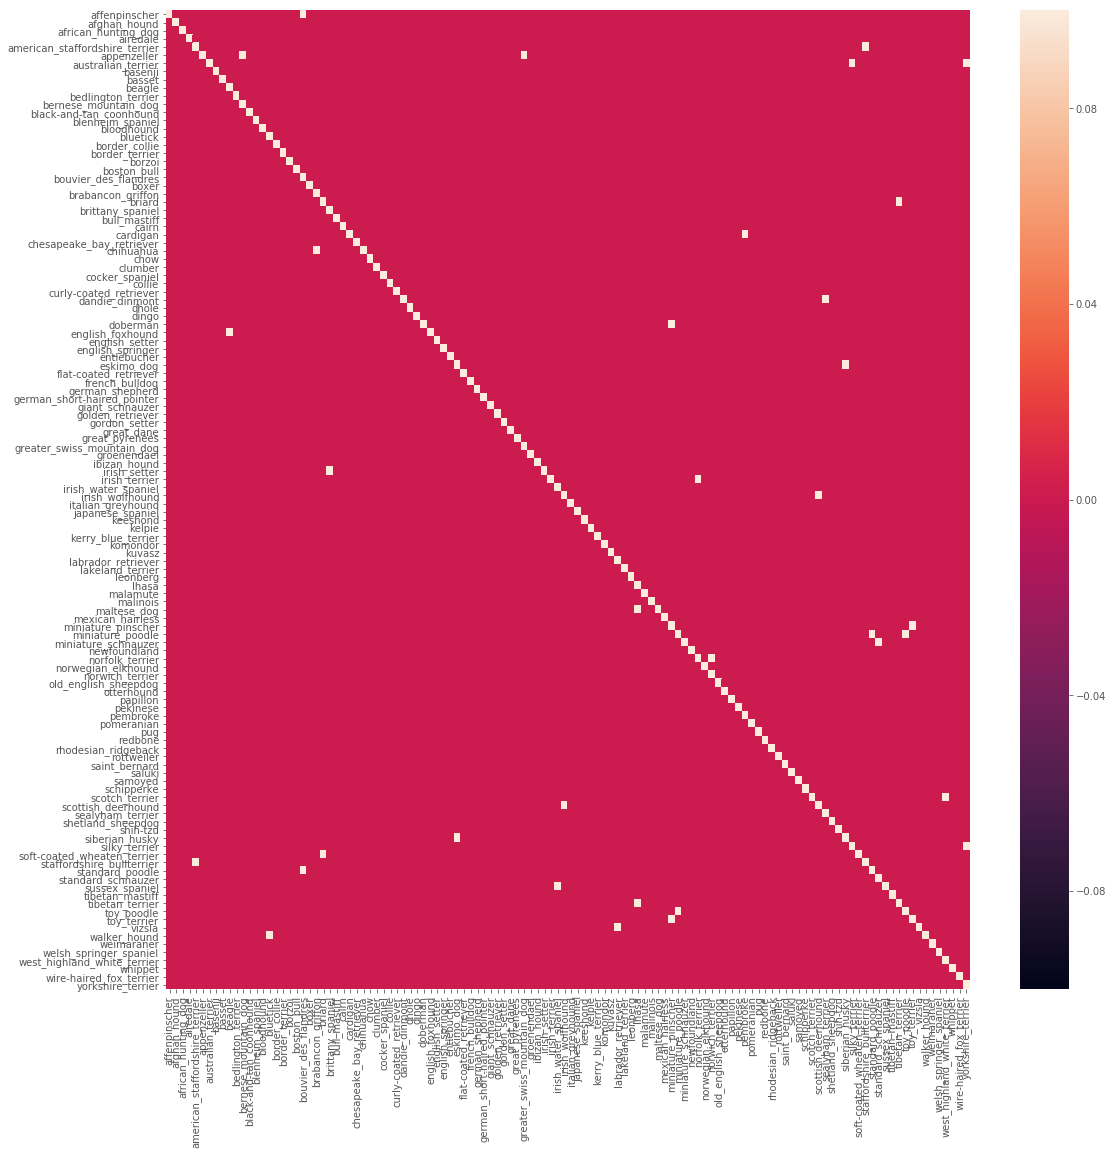

In [82]:
fig, ax = plt.subplots(figsize=(18, 18))
_ = sns.heatmap(cm, ax=ax, yticklabels=breeds, xticklabels=breeds, robust=True)

In [83]:
pr1=np.array(pr1)
pr1.shape
pr1=pr1.reshape(1023,1)

In [84]:
pr=np.array(pr)
pr=pr.reshape(1023,1)

In [85]:
x=np.concatenate((pr1,pr),axis=1)

In [86]:
x.shape

(1023, 2)

In [87]:
np.savetxt("somefile.csv",x,fmt="%s",header="actual,pred,count",delimiter=',',comments='')

In [88]:
df=pd.read_csv("somefile.csv")

In [89]:
df['count'] = 1

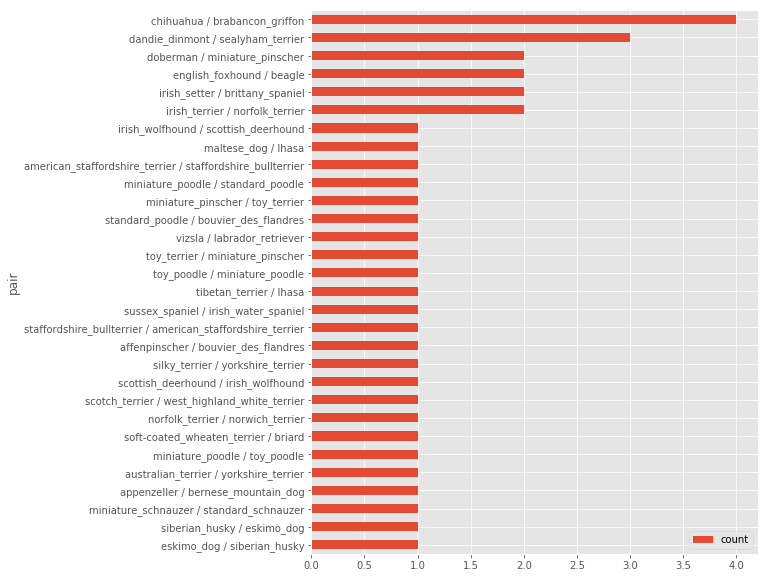

In [90]:

misclass_df = df[df['actual'] != df['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()
misclass_df['pair'] = misclass_df['actual'] + ' / ' + misclass_df['pred']
misclass_df = misclass_df[['pair', 'count']].take(range(30))

misclass_df.sort_values(['count']).plot.barh(figsize=(8, 10), x=misclass_df['pair'])

